In [340]:
import time, json, glob, os, itertools

import pandas as pd
import numpy as np

from py2neo import Graph, Node, Relationship
from tqdm import tqdm
from __future__ import print_function

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

In [214]:
graph = Graph("bolt://neo4j-magone:7687", auth=('neo4j','myneo'))

n_nodes = len(graph.nodes)
n_edges = len(graph.relationships)
print("Connected to graph with {:,} nodes and {:,} edges!".format(n_nodes, n_edges))

Connected to graph with 278,076,495 nodes and 1,842,505,331 edges!


In [215]:
def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

In [216]:
n_years_to_track = 15
min_year = 1950
citation_fun = lambda x: 'size((:Quanta {{year:q.year+{}}})-[:CITES]->(q)) as c{}'.format(x,x)
citation_string = '\n'+',\n'.join([citation_fun(i) for i in range(n_years_to_track)])

# query = """
# MATCH (q:Quanta) 
# WHERE q.year<=2018-{} AND q.year>{} AND size((:Quanta)-[:CITES]->(q))>1000
# WITH q, size((:Quanta)-[:CITES]->(q)) as numCitations
# ORDER BY numCitations DESC
# LIMIT 1000
# RETURN q.title as title, q.id as id, {}""".format(n_years_to_track, min_year, citation_string)

# df = run_query(query, graph, to_df=True, print_only=True)
# df.to_csv('/tmp/data/result/top_citations_over_time.csv')

In [217]:
df = pd.read_csv('/tmp/data/result/top_citations_over_time.csv')

citation_columns = ['c{}'.format(i) for i in range(n_years_to_track)]
name_columns = ['title', 'id'] 

df = df[citation_columns + name_columns]
X = df[citation_columns].values

df.describe()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14
count,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000,22965.000000
mean,9.112954,26.540997,41.729719,52.191465,60.715437,68.176442,74.794513,80.599565,86.067842,90.991422,95.825386,99.882473,102.338341,103.098890,100.227085
std,32.366671,48.438533,61.406622,70.782822,78.730382,87.027673,100.360215,107.569855,118.614248,127.375930,136.359992,144.623713,147.414154,150.650163,150.801706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,10.000000,14.000000,18.000000,21.000000,25.000000,29.000000,32.000000,36.000000,39.000000,40.000000,42.000000,42.000000,41.000000
50%,2.000000,13.000000,24.000000,33.000000,41.000000,48.000000,55.000000,61.000000,65.000000,68.000000,70.000000,71.000000,72.000000,72.000000,69.000000
75%,8.000000,32.000000,53.000000,68.000000,80.000000,88.000000,93.000000,98.000000,103.000000,107.000000,111.000000,115.000000,116.000000,115.000000,111.000000
max,2170.000000,2666.000000,3393.000000,3721.000000,3788.000000,3896.000000,6456.000000,6173.000000,6951.000000,7386.000000,7361.000000,6947.000000,6297.000000,6483.000000,6816.000000


Text(0.5, 0.98, 'Citations per year for articles with >1,000 citations for 15 years post-publication')

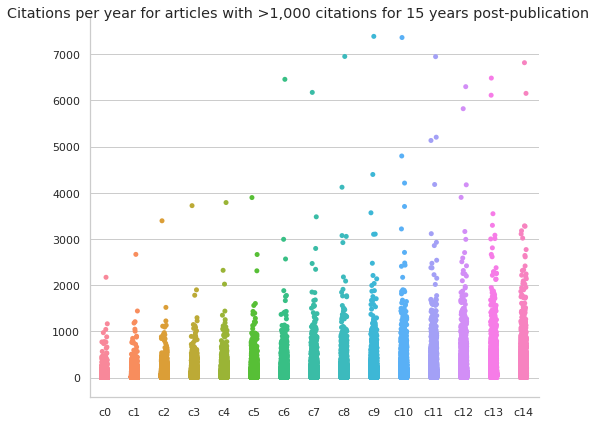

In [289]:
title = "Citations per year for articles with >1,000 citations for 15 years post-publication"
g = sns.catplot(data=df[citation_columns], height=6, aspect=1.2)
g.fig.suptitle(title)

Found 7,899 Venter-papers and 15,066 Bostein-papers


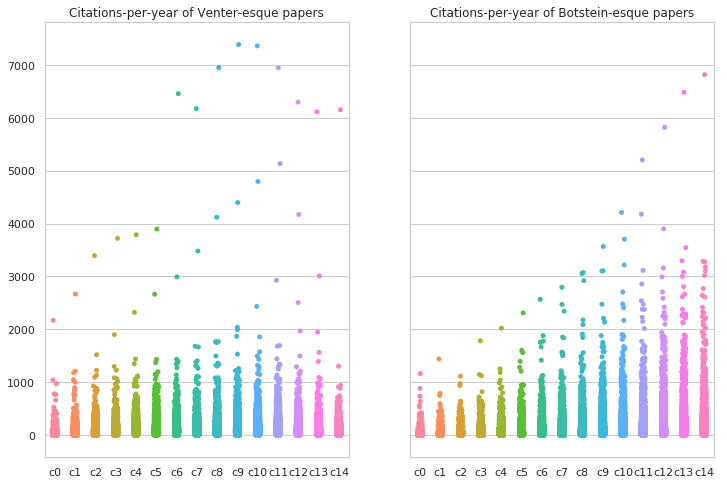

In [267]:
mask = (df['c6'] > df['c14']) & (df['c7'] > df['c14']) 
print("Found {:,} Venter-papers and {:,} Bostein-papers".format(sum(mask),sum(~mask)))

f, axes = plt.subplots(1,2, sharey=True)
sns.catplot(data=df[citation_columns].loc[mask], ax=axes[0])
axes[0].set_title("Citations-per-year of Venter-esque papers")

sns.catplot(data=df[citation_columns].loc[~mask], ax=axes[1])
axes[1].set_title("Citations-per-year of Botstein-esque papers")

plt.close(2)
plt.close(3)

In [268]:
p1 = 'DNA sequencing with chain-terminating inhibitors'
p2 = 'Gene ontology: tool for the unification of biology. The Gene Ontology Consortium.'
p3  = 'Initial sequencing and analysis of the human genome'

df['hue'] = mask+0.0

df['type'] = 'Venter-esque'
df.loc[~mask,'type'] = 'Botstein-esque'
df.loc[df['title']==p1,'type'] = 'DNA sequencing with chain-terminating inhibitors'
df.loc[df['title']==p2,'type'] = 'Gene ontology: tool for the unification of biology.'
df.loc[df['title']==p3,'type'] = p3

### PCA Analysis

In [269]:
# PCA Analysis of Citation Patterns 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
for i in range(3):
    print('Explained variance of principal component {}: {:.2%}'.format(
        i+1, pca.explained_variance_ratio_[i]))

Explained variance of principal component 1: 85.90%
Explained variance of principal component 2: 10.11%
Explained variance of principal component 3: 1.94%


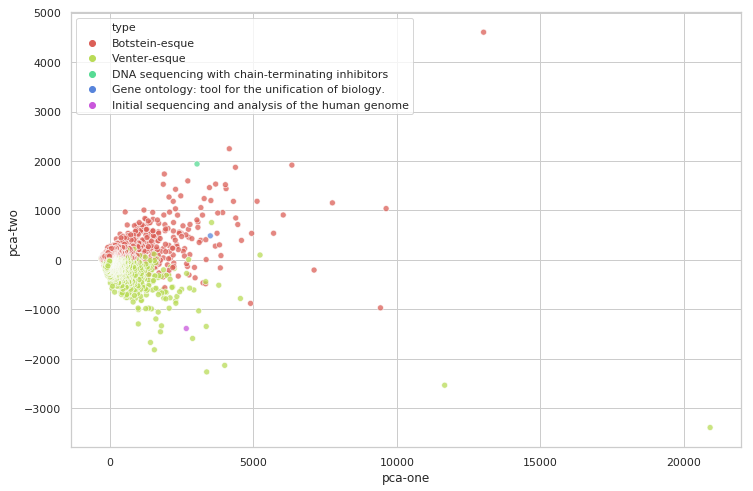

In [270]:
# Plot two components
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls",df['type'].nunique()),
    data=df,
    legend="full",
    alpha=0.75,
    hue="type"
)

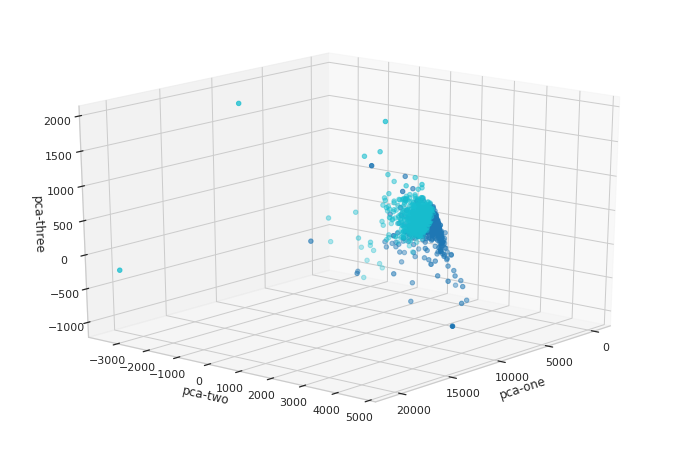

In [297]:
# Plot three components
ax = plt.gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["hue"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
ax.view_init(20, 40)
plt.show()

### T-SNE

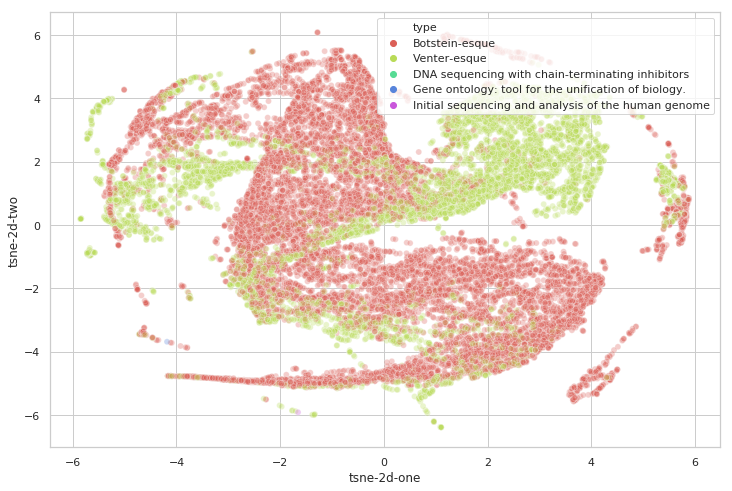

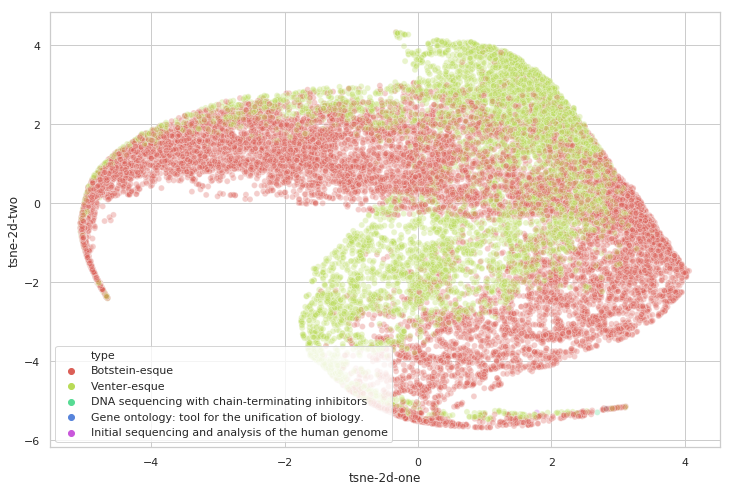

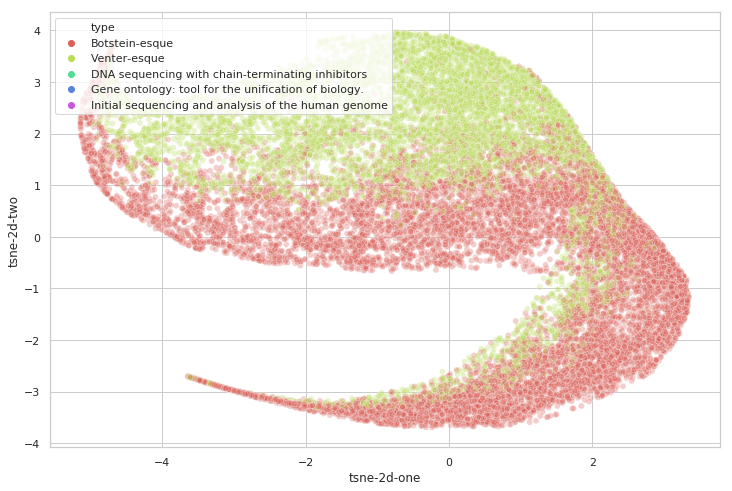

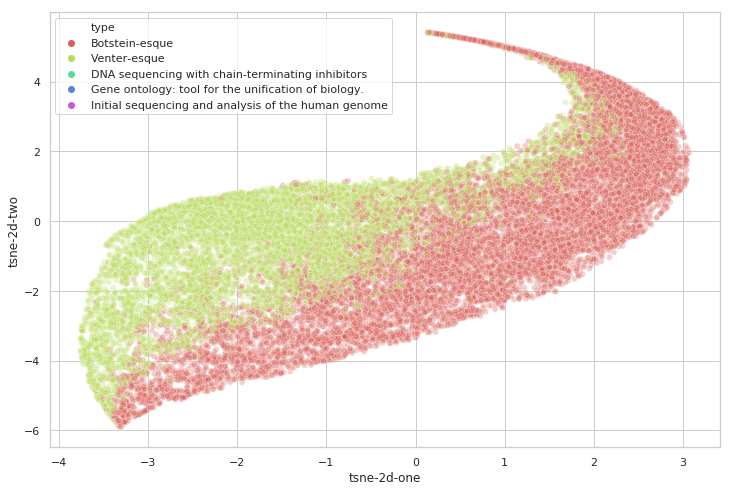

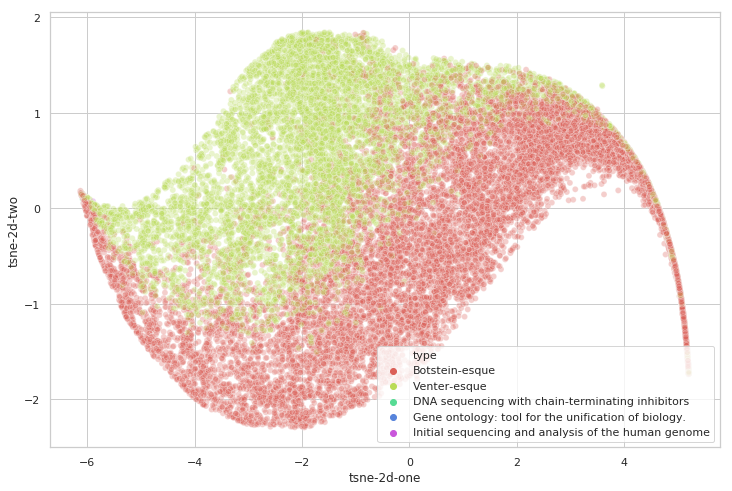

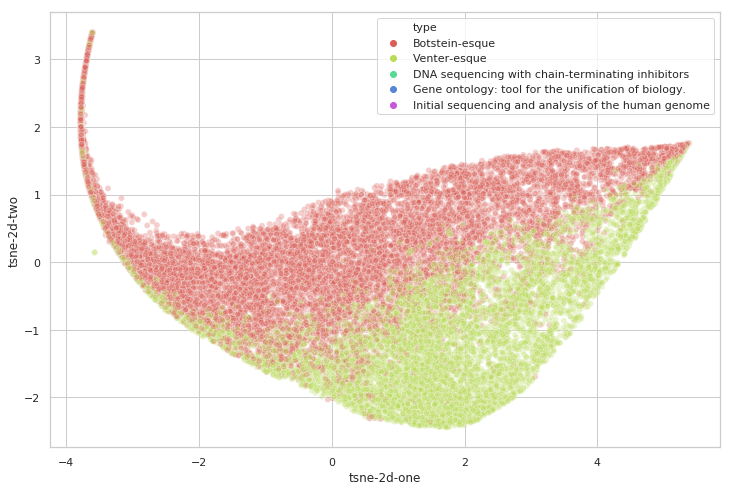

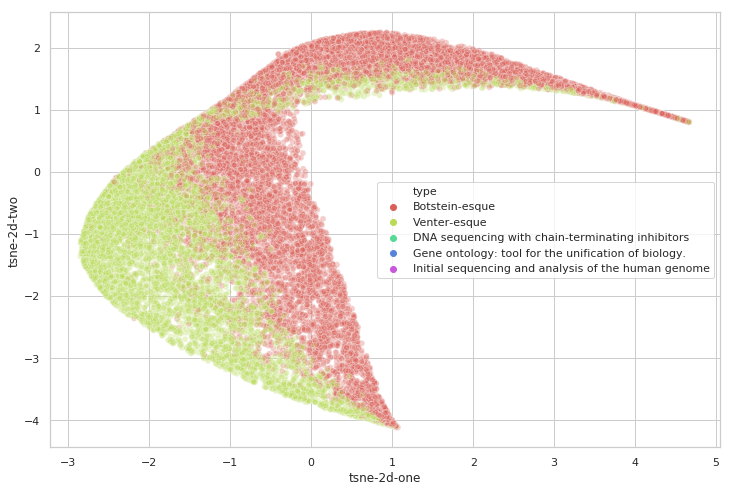

In [272]:
for p in [2,5,10,20,30,40,50]:
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=250)
    tsne_results = tsne.fit_transform(X)

    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]

    plt.figure()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="type",
        palette=sns.color_palette("hls",df['type'].nunique()),
        data=df,
        legend="full",
        alpha=0.3
    )

Text(0.5, 1.0, 'Botstein-esque')

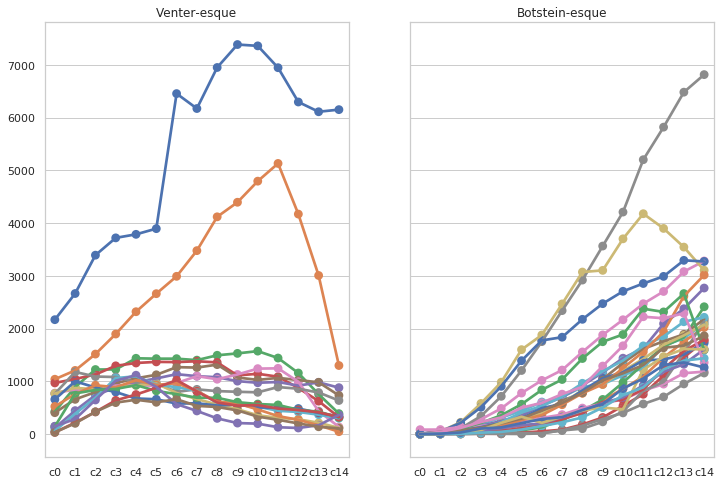

In [353]:
fig, ax = plt.subplots(1,2, sharey=True) 
palette = itertools.cycle(sns.color_palette())

for t in df.loc[df['pca-two']<-1000,'title']: 
    sns.pointplot(data=df[citation_columns].loc[df['title']==t],
                  ax=ax[0], color=next(palette), ci=None) 
ax[0].set_title("Venter-esque")
    
for t in df.loc[df['pca-two']>1000,'title']: 
    sns.pointplot(data=df[citation_columns].loc[df['title']==t],
                  ax=ax[1], color=next(palette), ci=None) 
ax[1].set_title("Botstein-esque")

In [351]:
print("Venter-esque")
for t in df.loc[df['pca-two']<-900,'title']:
    print("\t"+t)

print("Botstein-esque")
for t in df.loc[df['pca-two']>1000,'title']:
    print("\t"+t)

Venter-esque
	Molecular cloning : a laboratory manual
	Gapped BLAST and PSI-BLAST: a new generation of protein database search programs
	Case study research : design and methods
	The Seventh Report of the Joint National Committee on Prevention, Detection, Evaluation, and Treatment of High Blood Pressure: The JNC 7 Report
	Matrix computations
	Atherosclerosis — An Inflammatory Disease
	Quantum Computation and Quantum Information
	Statistical methods
	Initial sequencing and analysis of the human genome
	Numerical recipes in C
	Primer-directed enzymatic amplification of DNA with a thermostable DNA polymerase
	Inorganic Chemistry
	The Sequence of the Human Genome
	Chord: a scalable peer-to-peer lookup protocol for Internet applications
	Risks and benefits of estrogen plus progestin in healthy postmenopausal women: principal results From the Women's Health Initiative randomized controlled trial.
	Climate Change 2001: The Scientific Basis
	Ad hoc On-Demand Distance Vector (AODV) Routing
	Dup